# Residual integral anomaly detection

In [8]:
%reload_ext autoreload
%autoreload 2

import warnings
import math

import sys
sys.path.append('../')
from tsdr import tsdr
from tsdr.testseries import sockshop

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

In [4]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

def residual_integral(x: np.ndarray) -> np.ndarray:
    """
    Calculates the residual integral of the given time series.
    """
    if np.all(x == x[0]):
        return np.array([0.0])
    resids = OLS(x, add_constant(np.arange(1, x.size + 1))).fit().resid
    intersected_idxs: np.ndarray = np.where(np.diff(np.sign(resids)))[0] + 1
    sections = np.split(resids, indices_or_sections=intersected_idxs)
    return np.array([np.sum(sec**2) for sec in sections])

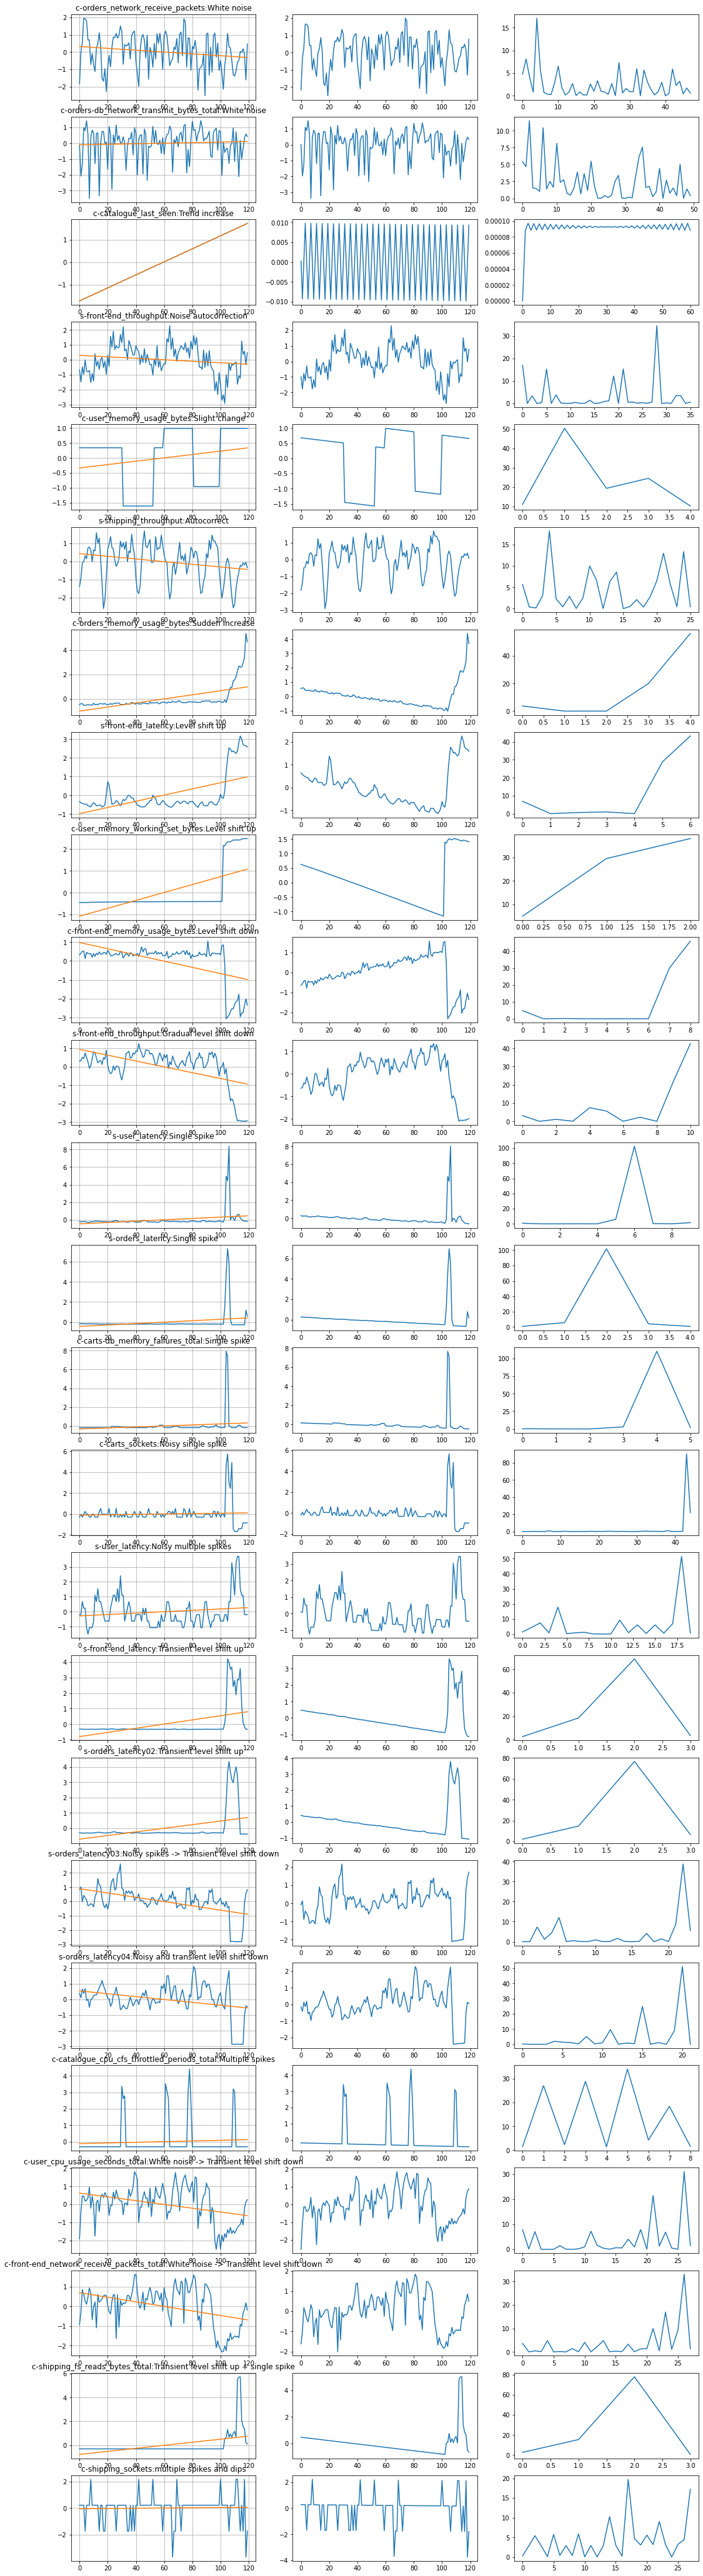

In [24]:
import scipy.stats

cases = sockshop.testcases_of_sockshop
fig, axs = plt.subplots(len(cases), ncols=3)
fig.set_size_inches(18, 3*len(cases))
for case, ax in zip(cases, axs):
    ts = scipy.stats.zscore(np.array(case['datapoints']))

    ax[0].set_title(f"{case['name']}:{case['pattern']}")
    ax[0].plot(ts)
    ax[0].grid()

    fit = OLS(ts, add_constant(np.arange(1, ts.size + 1))).fit()
    ax[0].plot(fit.predict())
    ax[1].plot(fit.resid)

    rsses = residual_integral(ts)
    ax[2].plot(rsses)

In [6]:
from meltria import loader

metrics_files = !find /datasets/argowf-chaos-hg68n/ -name "*.json" | grep -v network | grep '_0'
dataset, mappings = loader.load_dataset(metrics_files, exclude_middleware_metrics=True)
records = []
for (chaos_type, chaos_comp), sub_df in dataset.groupby(level=[0, 1]):
    for (metrics_file, grafana_dashboard_url), data_df in sub_df.groupby(level=[2, 3]):
        record = loader.DatasetRecord(chaos_type, chaos_comp, metrics_file, data_df)
        records.append(record)

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/interpolate/_fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


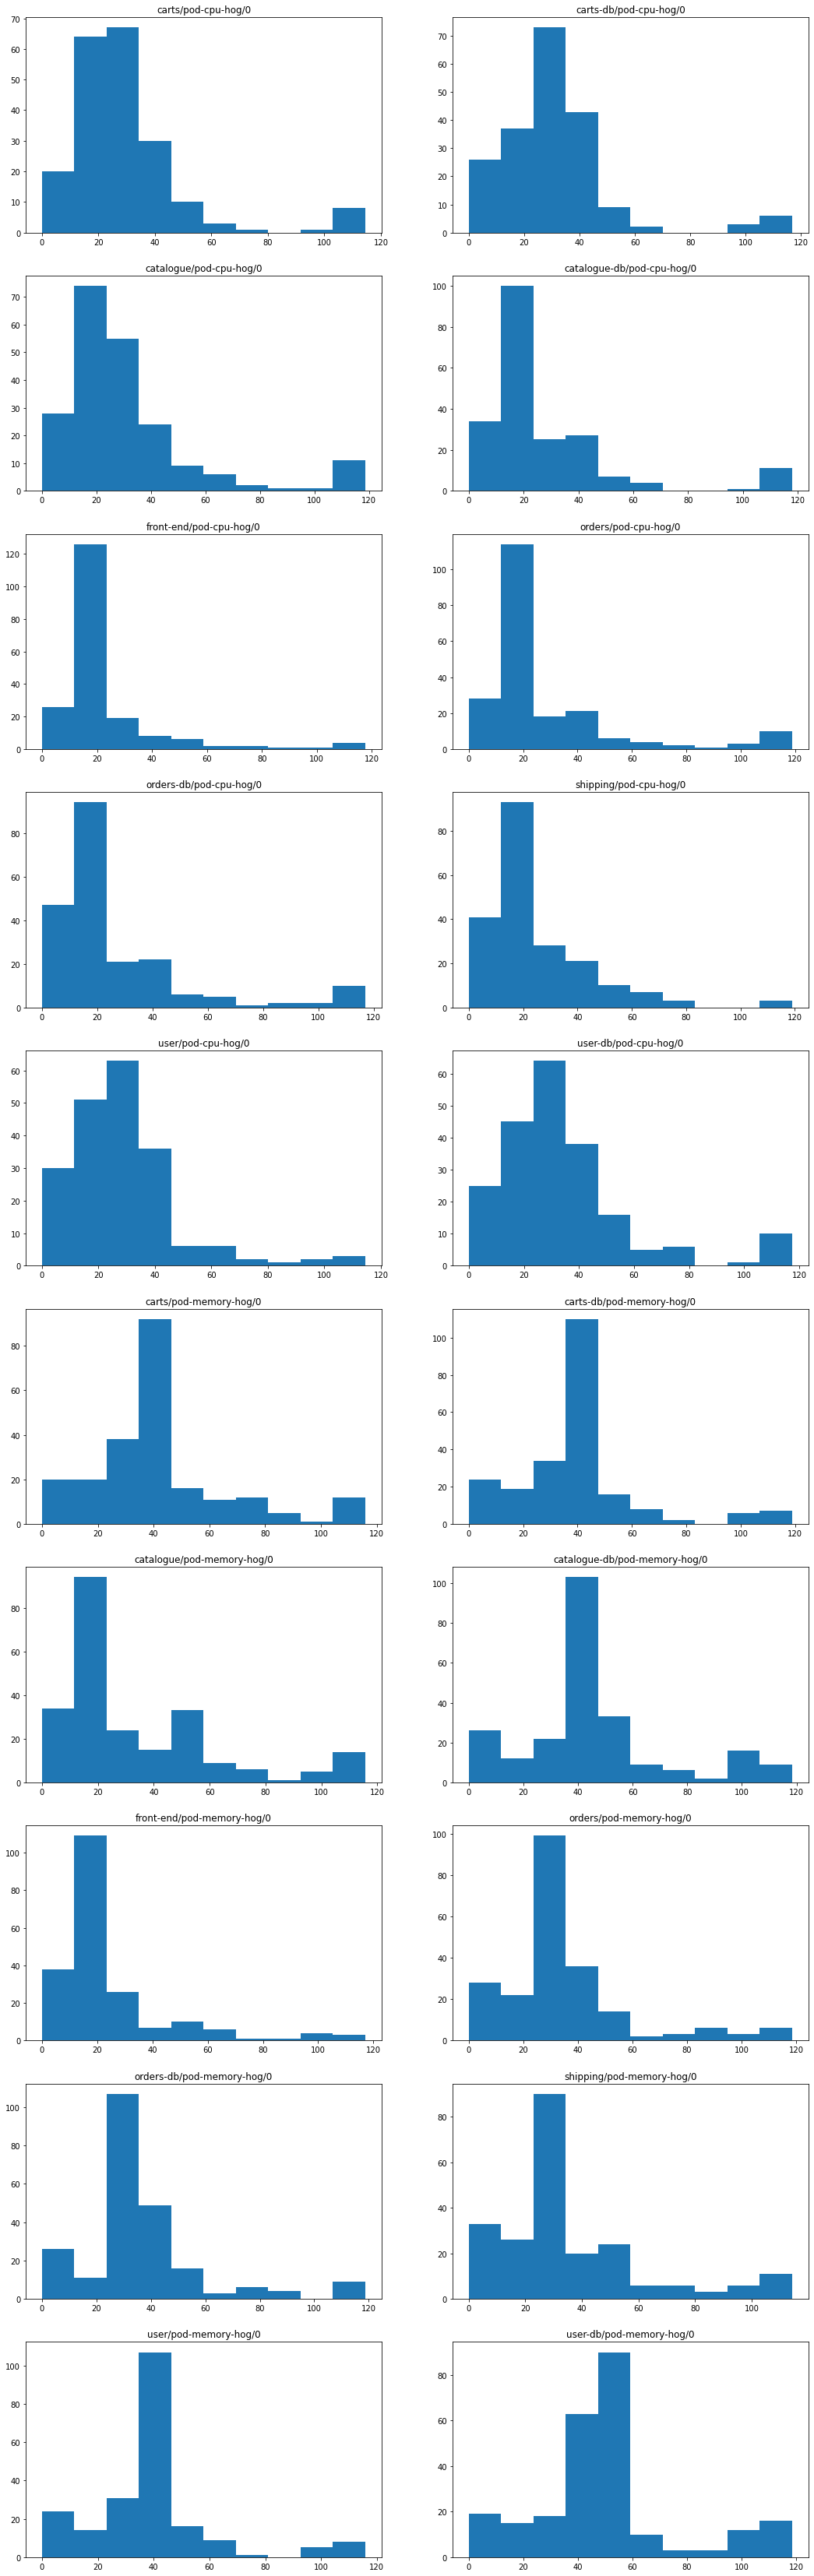

In [9]:
fig, axs = plt.subplots(math.ceil(len(records)//2), ncols=2)
fig.set_size_inches(18, 3*len(records))
rss_by_record = {}
for record, ax in zip(records, axs.flatten()):
    max_rsses = {}
    df = record.data_df
    for col in df.columns:
        ts = df[col].to_numpy()
        if np.all(ts == ts[0]):
            continue
        rsses = residual_integral(scipy.stats.zscore(ts))
        max_rsses[col] = np.max(rsses)
    ax.set_title(record.chaos_case_full())
    ax.hist(list(max_rsses.values()))
    rss_by_record[record.chaos_case_full()] = max_rsses

[ 46.34196482  41.88401585  41.68016292 107.36414932  42.52415137
  41.38484256  46.04740015  41.68016292 106.05455646 107.36414284
  41.68016292  42.00380378  41.68016292  41.42978231  41.64639613
  46.56134835  45.32231411  40.22875936  46.65645329  59.9057476
  53.18559139  43.69570746 101.83330203  53.18559139  45.08380861
  46.14660035  43.19433653  59.5449329   69.00239505 114.48387221
  38.69223616 113.17232429 113.17232429  42.19124072  40.55704432
  39.33713476 113.17232429  40.76380747  50.96331225 112.07172607
  40.49590012  40.49590012  63.86296958  48.42484853  47.01879661]
carts/pod-cpu-hog/0 min 38.69223616454614 max 114.48387220882098 len 45
(204,) (204,)
[1.16242042e+01 3.35184093e-29 6.43692275e-01 1.79308939e+01
 6.43692275e-01 1.42556176e+01 3.35184093e-29 1.27743156e+01
 1.28370311e+01 3.06506849e-02 7.58555892e+00 1.42522291e-05
 1.52408956e+01 1.25421757e+01 1.62973715e-01 3.35184093e-29
 1.04326255e+02 1.16743969e+02 3.35184093e-29 1.13470515e+02
 1.40964023e+01

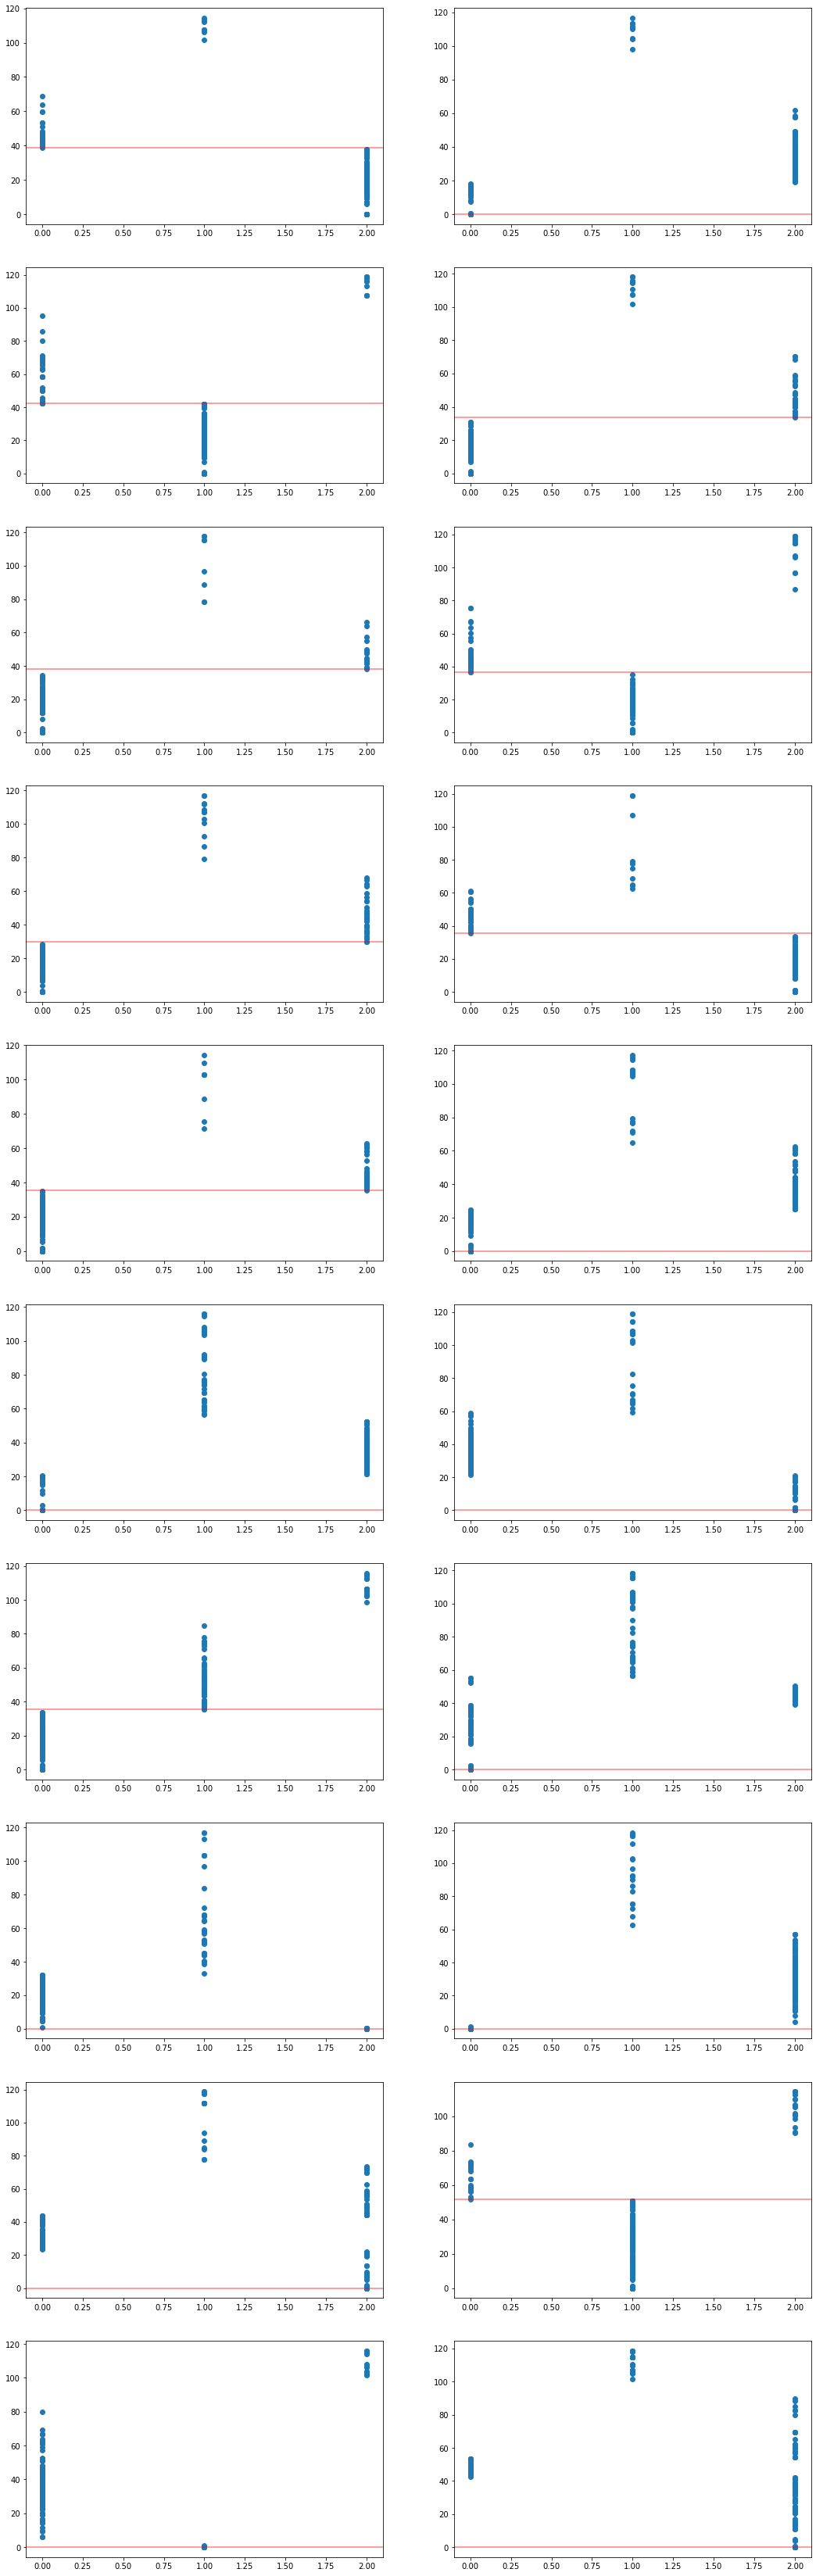

In [85]:
import sklearn.mixture

fig, axs = plt.subplots(math.ceil(len(records)//2), ncols=2)
fig.set_size_inches(18, 3*len(records))
for (case, max_rsses), ax in zip(rss_by_record.items(), axs.flatten()):
    rsses = np.array(list(max_rsses.values()))
    rsses = rsses[~np.isnan(rsses)]
    reshaped_x = rsses.reshape(-1, 1)
    labels = sklearn.mixture.GaussianMixture(n_components=3).fit(reshaped_x).predict(reshaped_x)
    unique, counts = np.unique(labels, return_counts=True)
    idx = np.argsort(-counts)
    anomaly_labels = unique[idx][1:]
    # print(counts, idx, anomaly_labels)
    anomaly_idx = np.where((labels == anomaly_labels[0]) | (labels == anomaly_labels[1]))[0]
    # print(labels)
    anomaly_rsses = rsses[anomaly_idx]
    print(anomaly_rsses)
    print(case, 'min', np.min(anomaly_rsses), 'max', np.max(anomaly_rsses), 'len', len(anomaly_rsses))
    # print([name for i, name in enumerate(max_rsses.keys()) if i in anomaly_idx])

    print(labels.shape, rsses.shape)
    ax.scatter(labels, rsses)
    ax.axhline(np.min(anomaly_rsses), color='red', alpha=0.5)


## Clustering jenkspy

[3.351840928816043e-29, 30.579075741658436, 69.00239504988382, 114.48387220882098]
[3.351840928816043e-29, 23.115266811239483, 61.92162908069369, 116.74396867184085]
[3.351840928816043e-29, 30.38744187739459, 71.31840764740866, 118.64981699903598]
[3.351840928816043e-29, 29.53586194497562, 70.26147418630335, 117.97017949588832]
[3.351840928816043e-29, 27.668583032918523, 66.29145874271903, 117.65000659990781]
[3.351840928816043e-29, 32.14226354018977, 75.3210992190759, 118.84962042548572]
[3.351840928816043e-29, 28.628126541082246, 67.93049003480823, 117.01685452955381]
[3.351840928816043e-29, 31.377135843198214, 68.76392300821863, 118.99958330476093]
[3.351840928816043e-29, 24.813684520808312, 62.58489749843128, 114.48228479461851]
[3.351840928816043e-29, 27.353260576943477, 64.84951449778309, 117.41213667952492]
[3.351840928816043e-29, 25.853272378273186, 65.43897968717641, 115.92572244045837]
[3.351840928816043e-29, 25.058268046913494, 70.95580230517993, 118.87960543726503]
[3.35184

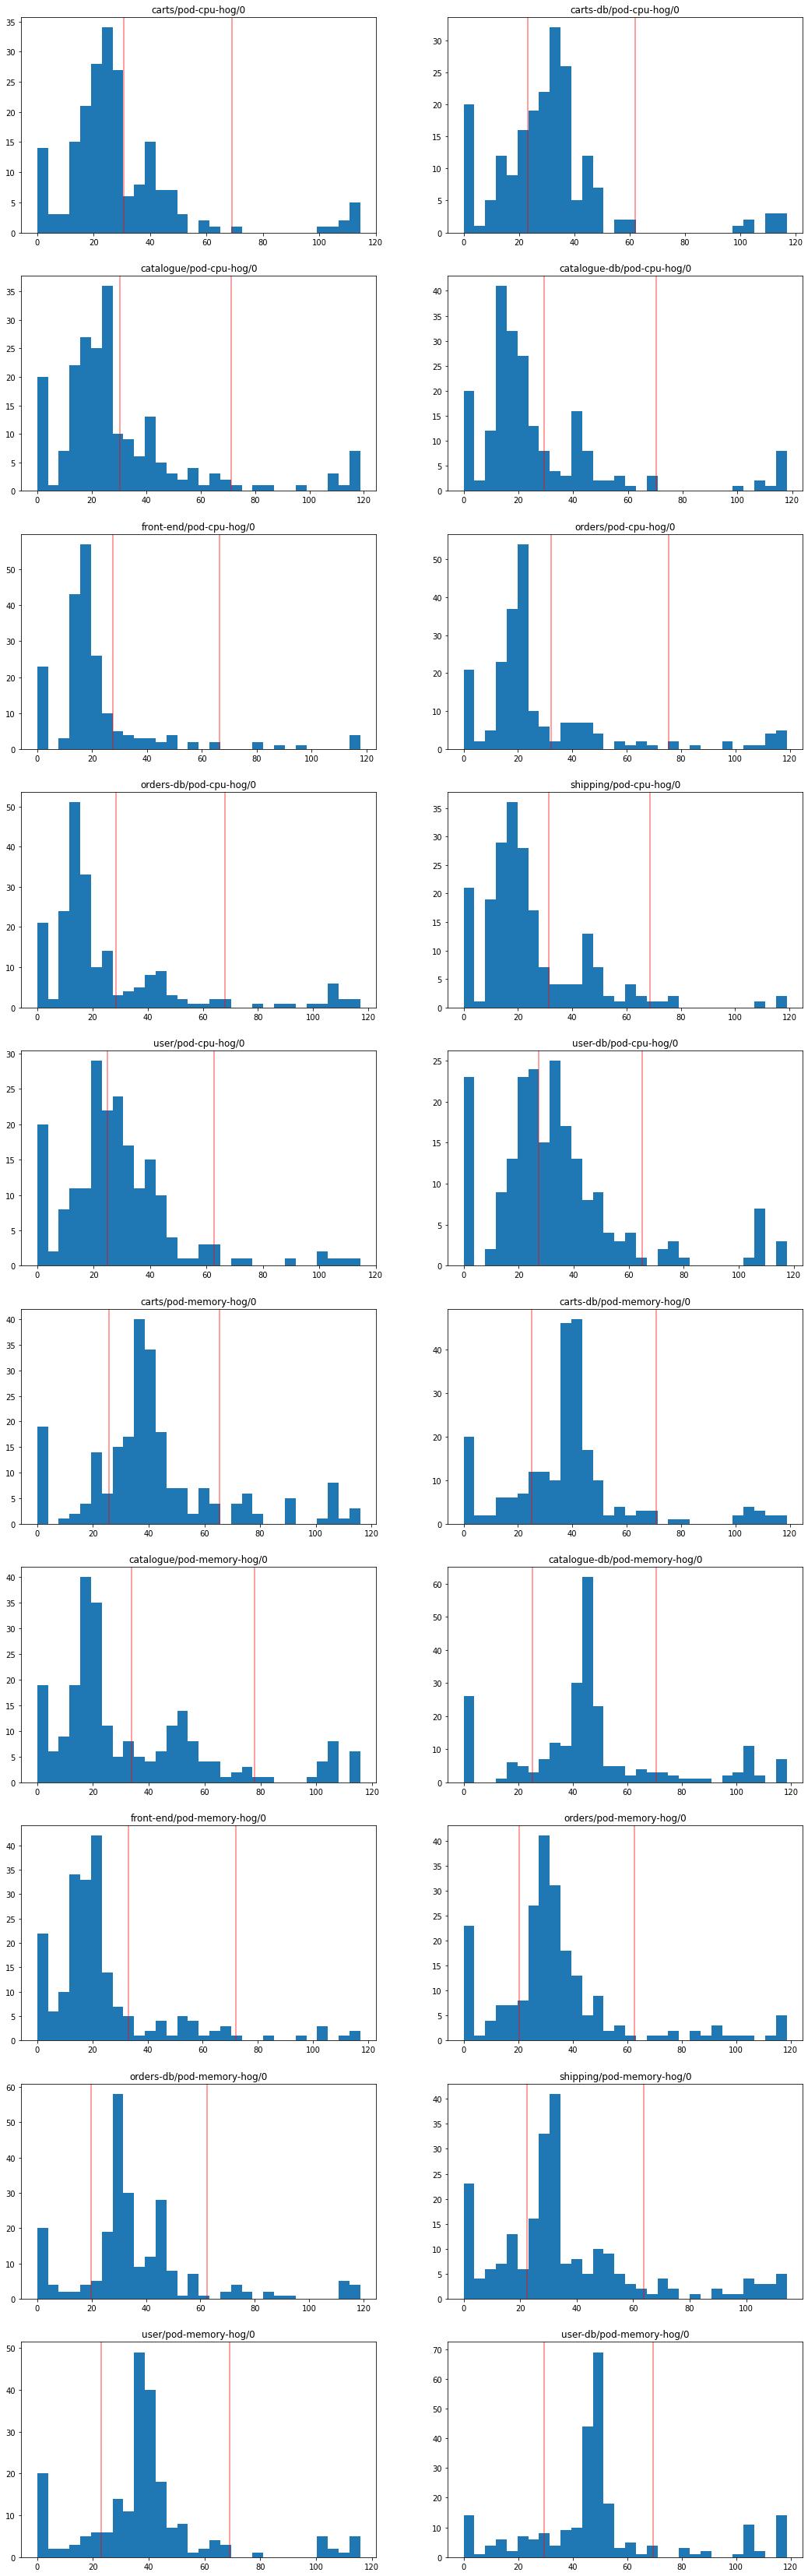

In [14]:
import jenkspy

fig, axs = plt.subplots(math.ceil(len(records)//2), ncols=2)
fig.set_size_inches(18, 3*len(records))
for (case, max_rsses), ax in zip(rss_by_record.items(), axs.flatten()):
    rsses = np.array(list(max_rsses.values()))
    rsses = rsses[~np.isnan(rsses)]
    breaks = jenkspy.jenks_breaks(rsses, nb_class=3)
    ax.hist(rsses, bins=30)
    print(breaks)
    for bkp in breaks[1:-1]:
        ax.axvline(bkp, color='red', alpha=0.5)
    ax.set_title(case)
    ax.set_xticks(np.arange(0, np.max(rsses), 5))